# CN model run

In [118]:
# Load packages without warnings and messages
suppressPackageStartupMessages({
  library(dplyr)
  library(tidyr)
  library(ggplot2)
  library(patchwork)
  library(cowplot)
  library(visdat)
  library(here)
  library(lubridate)
  library(readr)
  library(naniar)
  library(purrr)
  library(rsofun)
})

In [119]:
# load drivers data
drivers <- readRDS("../data/CH-Oe2_2004-2023_final_ready_for_CNmodel_run.rds")
colnames(drivers$forcing[[1]])

[1] "date"   "temp"   "vpd"    "ppfd"   "netrad" "patm"   "snow"   "rain"  
 [9] "tmin"   "tmax"   "vwind"  "fapar"  "co2"    "ccov"   "nee"    "dno3"  
[17] "dnh4"   "fharv"  "cseed"  "nseed"

In [120]:
str(drivers$forcing[[1]])

tibble [7,300 x 20] (S3: tbl_df/tbl/data.frame)
 $ date  : Date[1:7300], format: "2004-01-01" "2004-01-02" ...
 $ temp  : num [1:7300] -0.389 -1.069 -3.389 -5.489 -2.451 ...
 $ vpd   : num [1:7300] 0.0651 0 0.0709 0.76 0.2393 ...
 $ ppfd  : num [1:7300] 6.51 7.12 7.13 9.54 6.73 ...
 $ netrad: num [1:7300] 1.34 -4.38 -4.58 -9.02 -6.91 ...
 $ patm  : num [1:7300] 95825 95455 96232 96367 96710 ...
 $ snow  : num [1:7300] 0 0 0 0 0 0 0 0 0 0 ...
 $ rain  : num [1:7300] 1.6 0.5 0 0 0 0 0.4 16.6 8.9 7.8 ...
 $ tmin  : num [1:7300] -1.23 -2.06 -5.82 -10.45 -8.1 ...
 $ tmax  : num [1:7300] -0.01 -0.05 -2.19 -1.48 0.53 0.35 4.14 1 6.48 7.47 ...
 $ vwind : num [1:7300] 1.52 2.022 2.716 1.089 0.675 ...
 $ fapar : num [1:7300] 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.09 0.09 ...
 $ co2   : num [1:7300] 385 378 386 402 437 ...
 $ ccov  : num [1:7300] 100 93.7 100 77.6 87 ...
 $ nee   : num [1:7300] 0.761 0.788 0.769 0.815 0.746 ...
 $ dno3  : num [1:7300] 0 0 0 0 0 0 0 0 0 0 ...
 $ dnh4  : num [1:

In [121]:
# Check date range and completeness of forcing data
forcing_data <- drivers$forcing[[1]]
date_range <- range(forcing_data$date)
cat("Date range:", as.character(date_range[1]), "to", as.character(date_range[2]), "\n")

# Check if years are complete
years_in_data <- year(forcing_data$date)
unique_years <- unique(years_in_data)
cat("Years in data:", paste(unique_years, collapse = ", "), "\n")

# Check completeness of each year
year_completeness <- forcing_data %>%
  mutate(year = year(date)) %>%
  group_by(year) %>%
  summarise(
    n_days = n(),
    start_date = min(date),
    end_date = max(date),
    is_leap = leap_year(year[1]),
    expected_days = ifelse(is_leap, 366, 365),
    complete = n_days == expected_days,
    .groups = 'drop'
  )

print(year_completeness)

# Identify incomplete years
incomplete_years <- year_completeness$year[!year_completeness$complete]
if(length(incomplete_years) > 0) {
  cat("Incomplete years found:", paste(incomplete_years, collapse = ", "), "\n")
} else {
  cat("All years are complete\n")
}

Date range: 2004-01-01 to 2023-12-31 
Years in data: 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023 
# A tibble: 20 x 7
    year n_days start_date end_date   is_leap expected_days complete
   <dbl>  <int> <date>     <date>     <lgl>           <dbl> <lgl>   
 1  2004    365 2004-01-01 2004-12-31 TRUE              366 FALSE   
 2  2005    365 2005-01-01 2005-12-31 FALSE             365 TRUE    
 3  2006    365 2006-01-01 2006-12-31 FALSE             365 TRUE    
 4  2007    365 2007-01-01 2007-12-31 FALSE             365 TRUE    
 5  2008    365 2008-01-01 2008-12-31 TRUE              366 FALSE   
 6  2009    365 2009-01-01 2009-12-31 FALSE             365 TRUE    
 7  2010    365 2010-01-01 2010-12-31 FALSE             365 TRUE    
 8  2011    365 2011-01-01 2011-12-31 FALSE             365 TRUE    
 9  2012    365 2012-01-01 2012-12-31 TRUE              366 FALSE   
10  2013    365 2013-01-01 2013-12-31 FALSE      

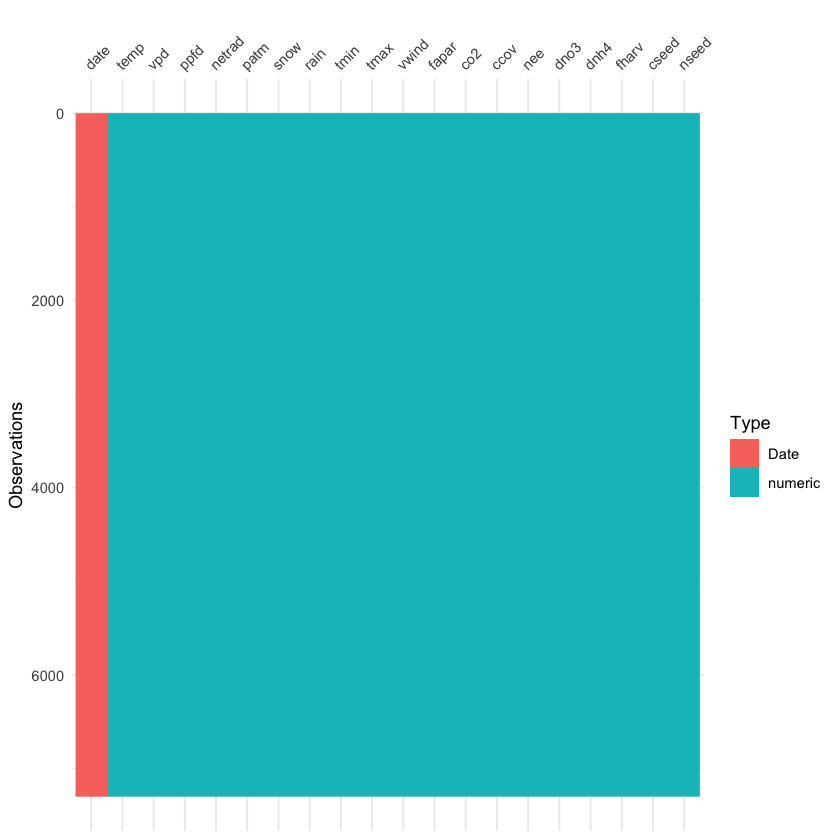

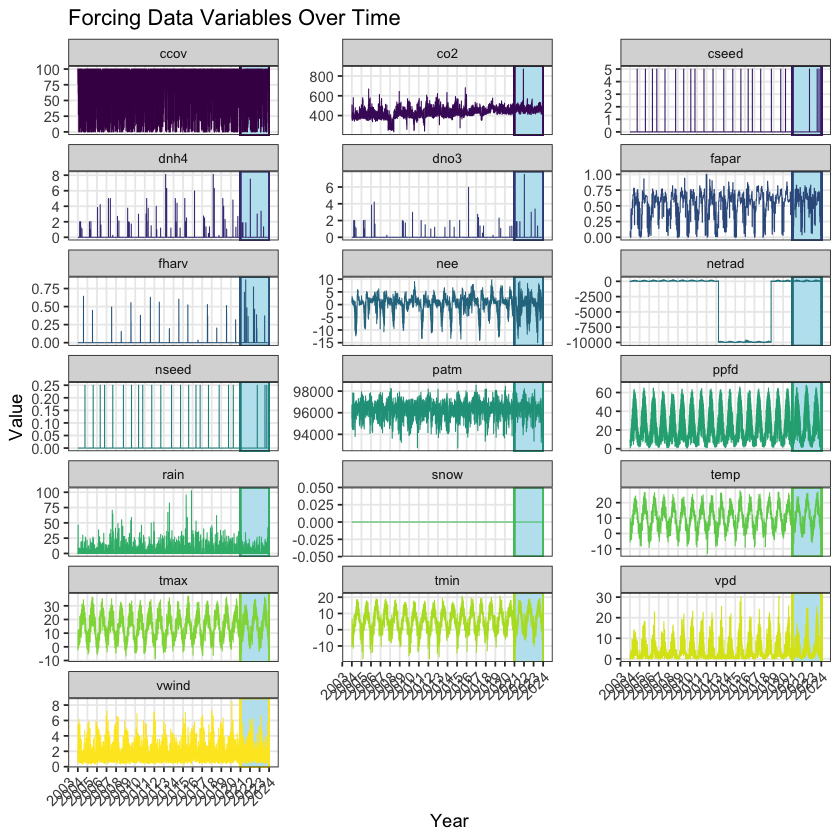

In [122]:
# check the data patterns in the forcing data
vis_dat(drivers$forcing[[1]], warn_large_data = TRUE)

# Plot all columns in the forcing data with different colors
plot_forcing <- drivers$forcing[[1]] %>%
    select(date, everything()) %>%
    pivot_longer(cols = -date, names_to = "variable", values_to = "value") %>%
    ggplot(aes(x = date, y = value, color = variable)) +
    # highlight the area from 2021 to 2023
    geom_rect(aes(xmin = as.Date("2021-01-01"), xmax = as.Date("2023-12-31"), ymin = -Inf, ymax = Inf), 
              fill = "#bde2ef", alpha = 0.2) +
    geom_line(linewidth = 0.3) +
    facet_wrap(~variable, scales = "free_y", ncol = 3) +
    scale_x_date(date_labels = "%Y", date_breaks = "1 years") +
    scale_color_viridis_d() +  # Use viridis color palette for different colors
    labs(title = "Forcing Data Variables Over Time",
         x = "Year",
         y = "Value") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          strip.text = element_text(size = 8),
          panel.grid.minor = element_blank(),
          legend.position = "none")  # Hide legend since colors are redundant with facets

# Save the plot
ggsave("../data/forcing_data_variables.png", plot_forcing, width = 20, height = 10, dpi = 300, bg = "white")
plot_forcing


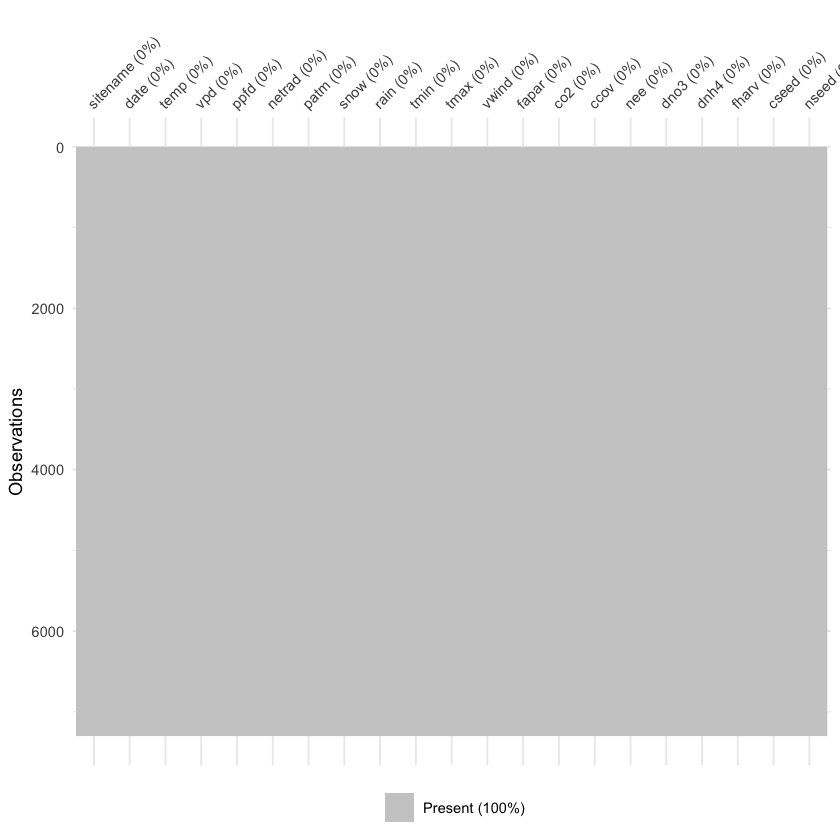

In [123]:
# Check for missing values in the drivers object in forcing data
### check for missing values in the data----------------
miss_plot <- drivers |>
  select(sitename, forcing) |>
  unnest(forcing) |>
  vis_miss(warn_large_data = FALSE)

ggsave("../data/01_vis_miss_drivers.png", miss_plot, width = 10, height = 6)
miss_plot

# Error handling for leap year data
- The model was giving errors when it was run with leap year data, so we are removing the leap year data from the forcing data.
- This is done by removing the rows where date contains "-02-29".

In [124]:
# Define model parameters taken from p model script and other scripts
pars <- list(
  # Paramteres taken from P-model
  kphio = 0.045,             # setup ORG in Stocker et al. 2020 GMD  #typical ranges: 0.04-0.1 #lma / fapar / gpp / leaf c / cturnover / Vcmax 
  kphio_par_a = 0.0,        # set to zero to disable temperature-dependence of kphio
  kphio_par_b = 1.0,
  soilm_thetastar = 0.6 * 240,  # to recover old setup with soil moisture stress
  soilm_betao = 0.0,
  beta_unitcostratio = 146.0,
  rd_to_vcmax = 0.014,      # value from Atkin et al. 2015 for C3 herbaceous # cturnover / Vcmax
  tau_acclim = 30.0,
  kc_jmax = 0.41,
  
  # Plant
  f_nretain = 0.500000, #0.5 # cturnover
  fpc_tree_max = 0.8000000, #typical range: 0.8-0.95. #fapar / c leaf
  growtheff = 0.6000000, #0.45  #typical range: 0.3-0.7 #lma / c leaf / cturnover
  r_root = 2*0.913000,
  r_sapw = 2*0.044000,
  exurate = 0.003000,
  
  k_decay_leaf = 1.90000, #1.90000, #typical range: 0.5 - 2.0 # cleaf / cturnover
  k_decay_root = 1.90000, # cturnover
  k_decay_labl = 1.90000, #1.90000, #typical range: 0.5 - 2.0 # cleaf / cturnover
  k_decay_sapw = 1.90000, # cturnover
  
  r_cton_root = 37.0000, # cturnover
  r_cton_wood = 100.000, # cturnover
  r_cton_seed = 15.0000, # cturnover
  nv_vcmax25 = 5000, #0.02 * 13681.77, # see ln_cn_review/vignettes/analysis_leafn_vcmax_field.Rmd, l.695; previously: 5000.0, #lma / Vcmax
  ncw_min = 0.056, #0.08 * 1.116222, # see ln_cn_review/vignettes/analysis_leafn_vcmax_field.Rmd, l.691; previously used: 0.056, #lma
  r_n_cw_v = 0.05, #0.1, # assumed that LMA is independent of Vcmax25; previously: 0.1, #lma /Vcmax #typical range: 0.05-0.2 
  r_ctostructn_leaf = 30.0000, #1.3 * 45.84125, # see ln_cn_review/vignettes/analysis_leafn_vcmax_field.Rmd, l.699; previously used: 80.0000, #typical range: 40-80 #lma / fapar / cleaf 
  kbeer = 0.350000, #0.400000 #fapar #typical range: 0.3-0.8
  
  # Phenology (should be PFT-specific)
  gddbase = 5.0, #typical range: 5-10 #c leaf 
  ramp = 0.0,
  phentype = 2.0,
  
  # Soil physics (should be derived from params_soil, fsand, fclay, forg, fgravel)
  perc_k1 = 5.0,
  thdiff_wp = 0.2,
  thdiff_whc15 = 0.8,
  thdiff_fc = 0.4,
  forg = 0.01,
  wbwp = 0.029,
  por = 0.421,
  fsand = 0.82,
  fclay = 0.06,
  fsilt = 0.12,
  
  # Water and energy balance
  kA = 107,
  kalb_sw = 0.17,
  kalb_vis = 0.03,
  kb = 0.20,
  kc = 0.25,
  kCw = 1.05,
  kd = 0.50,
  ke = 0.0167,
  keps = 23.44,
  kWm = 220.0,
  kw = 0.26,
  komega = 283.0,
  maxmeltrate = 3.0,
  
  # Soil BGC
  klitt_af10 = 1.2,
  klitt_as10 = 0.35,
  klitt_bg10 = 0.35,
  kexu10 = 50.0,
  ksoil_fs10 = 0.021,
  ksoil_sl10 = 7.0e-04,
  ntoc_crit1 = 0.45,
  ntoc_crit2 = 0.76,
  cton_microb = 10.0,
  cton_soil = 9.77,
  fastfrac = 0.985,
  
  # N uptake
  eff_nup = 0.0001000,
  minimumcostfix = 1.000000,
  fixoptimum = 25.15000,
  a_param_fix = -3.62000,
  b_param_fix = 0.270000,
  
  # Inorganic N transformations (re-interpreted for simple ntransform model)
  maxnitr =  0.00005,
  
  # Inorganic N transformations for full ntransform model (not used in simple model)
  non = 0.01,
  n2on = 0.0005,
  kn = 83.0,
  kdoc = 17.0,
  docmax = 1.0,
  dnitr2n2o = 0.01,
  
  # Additional parameters - previously forgotten
  frac_leaf = 0.4,         # after wood allocation  #typical range: 0.4-0.8 #lma / fapar / c leaf / cturnover
  frac_wood = 0,           # highest priority in allocation  #typical range: 0-0.6 #lma / cleaf 
  frac_avl_labl = 0.1, #0.1   #typical range: 0.1-0.3 # c leaf 
  
  # for development
  tmppar = 9999,
  
  # simple N uptake module parameters
  nuptake_kc = 600,
  nuptake_kv = 5,
  nuptake_vmax = 0.3 #0.3 #typical range: 0.1-0.3 # cleaf / cturnover
)

# make dir
if (!dir.exists("../output")) {
  dir.create("../output")
}
# Function to run the model and save the output
cnmodel_run_save <- function(drivers, pars, save_path, file_basename) {
  output_04_23 <- runread_cnmodel_f(drivers = drivers, 
                                    par = pars,
                                    ncores = 12,
                                    makecheck = FALSE,  # Set to FALSE to avoid strict checks
                                    parallel = TRUE
  )
  rds_filename <- paste0(file_basename, ".rds")
  if (!dir.exists(save_path)) {
    stop("Directory does not exist: ", save_path)
  }
  saveRDS(output_04_23, file = file.path(save_path, rds_filename))
  message("Model output saved: ", file.path(save_path, rds_filename))
  invisible(output_04_23)
}
# Example usage:
# Run the model with filtered data (complete years only)
cnmodel_run_save(drivers, pars, "../output", "output_04_23")
# Read the output
output_04_23 <- readRDS("../output/output_04_23.rds")

Using partial cluster of size 1

Model output saved: ../output/output_04_23.rds



# Plot output results

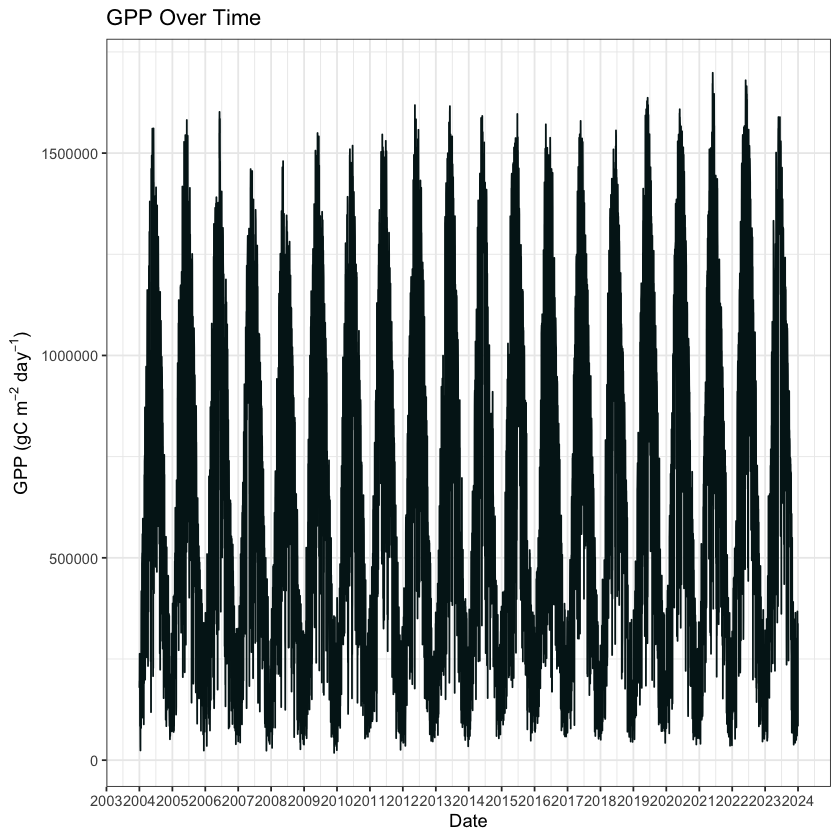

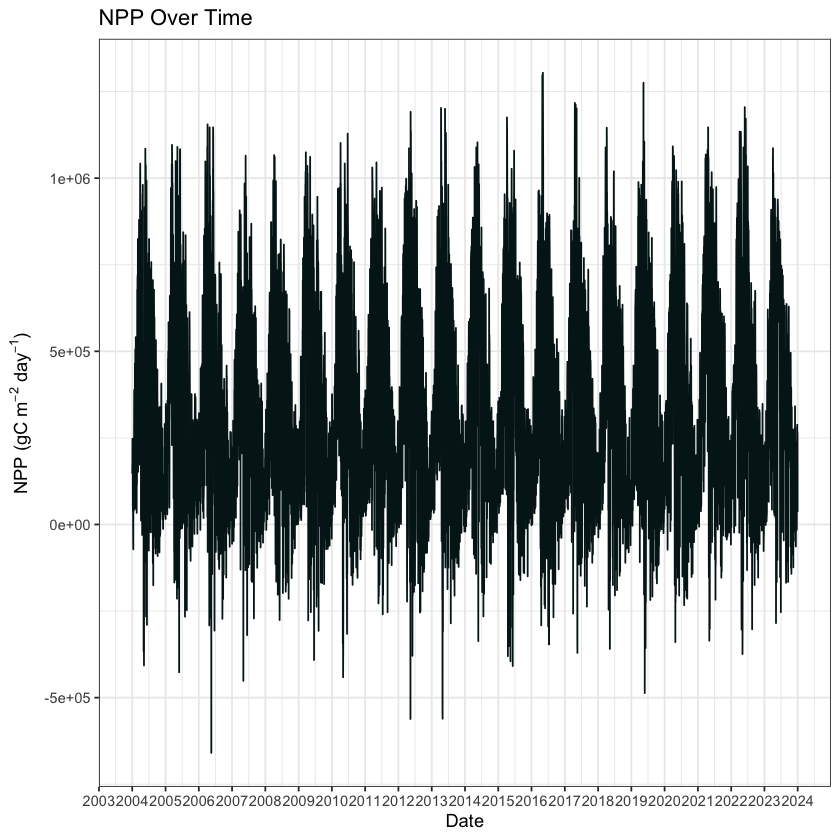

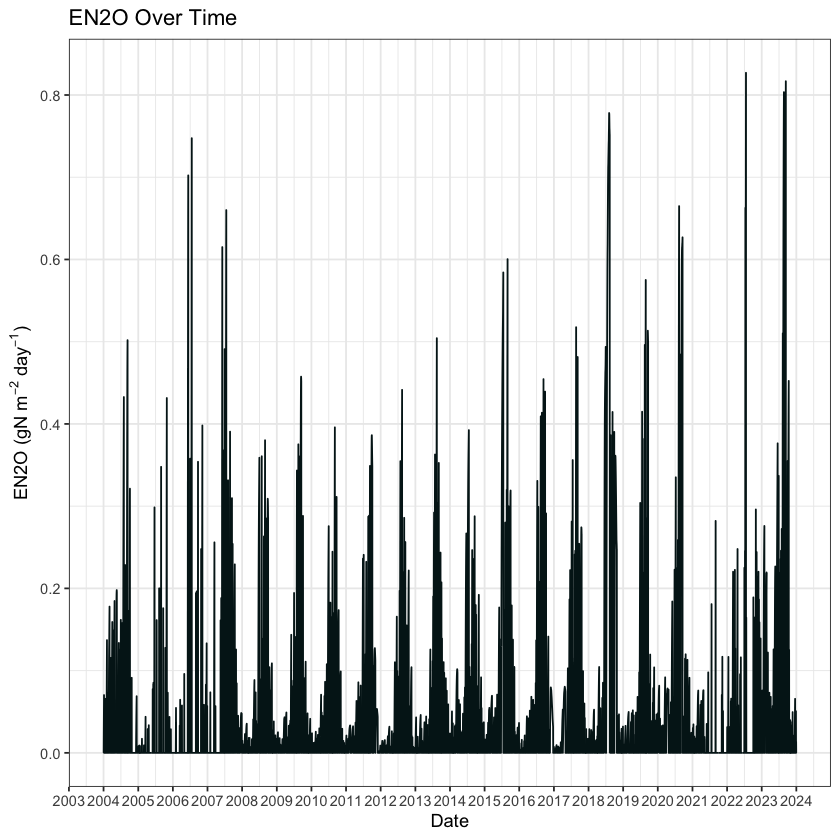

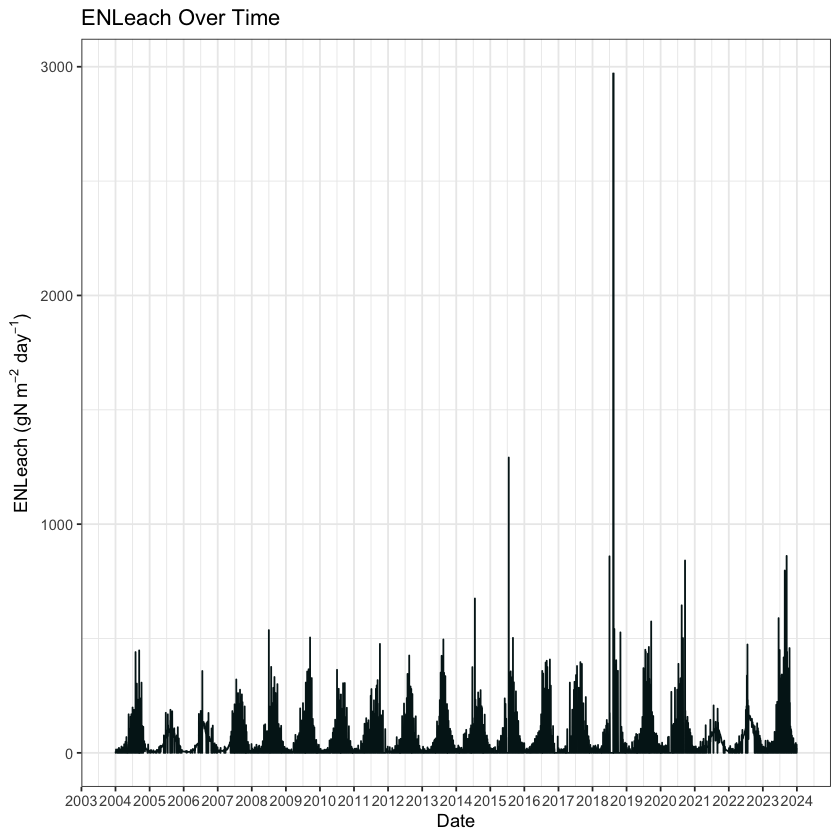

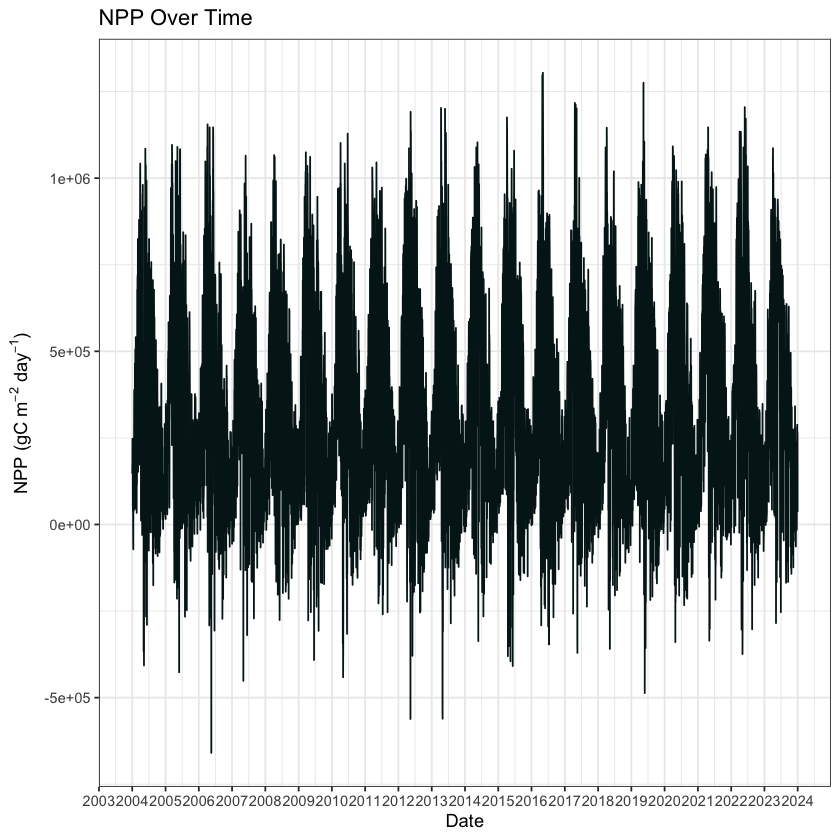

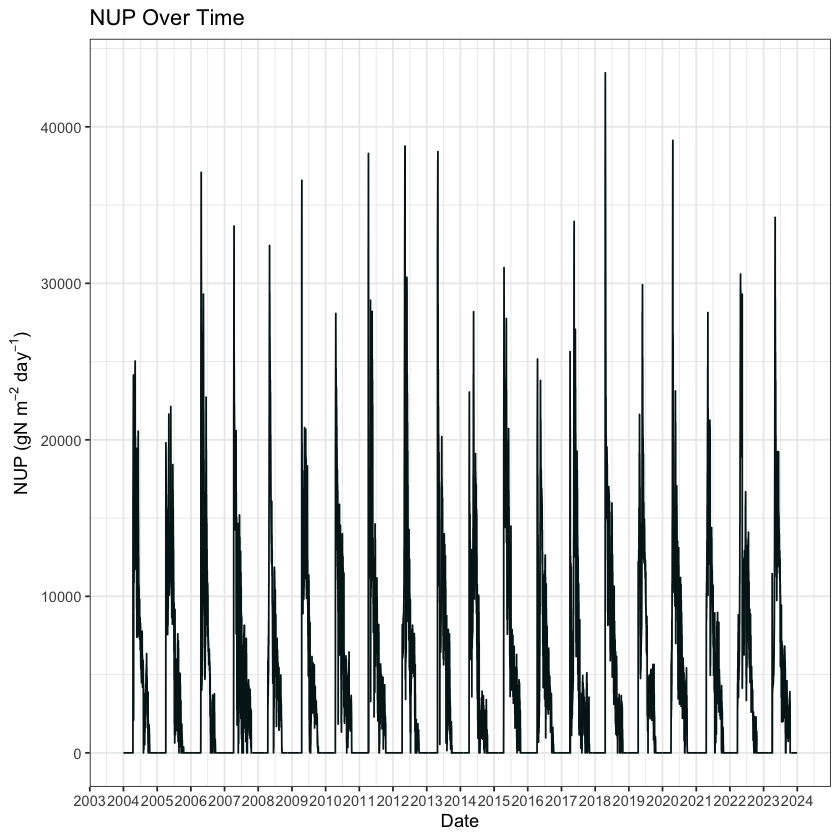

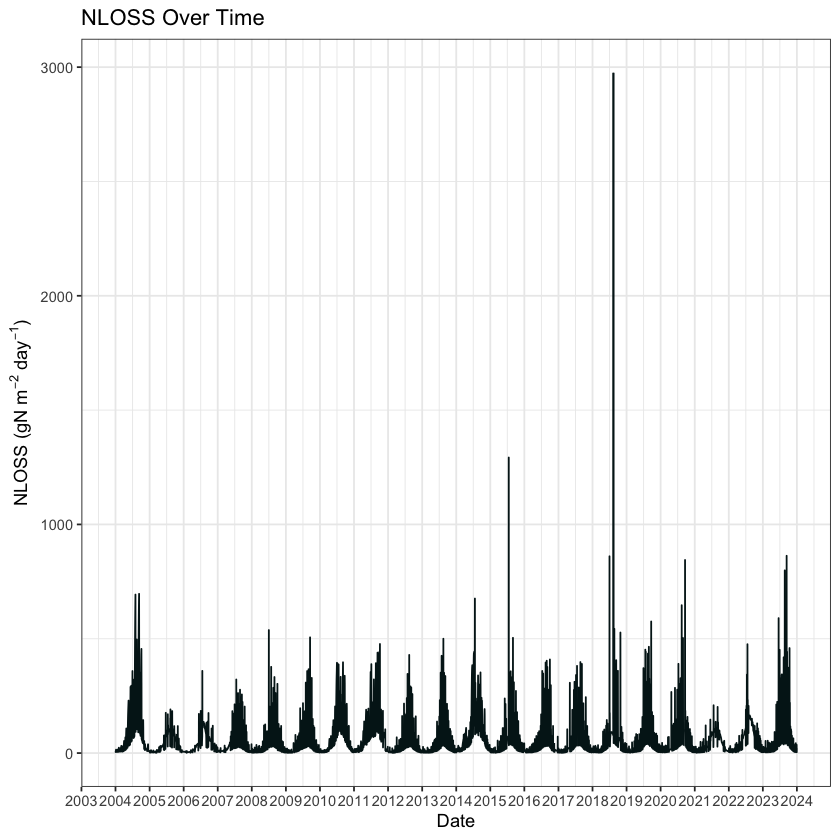

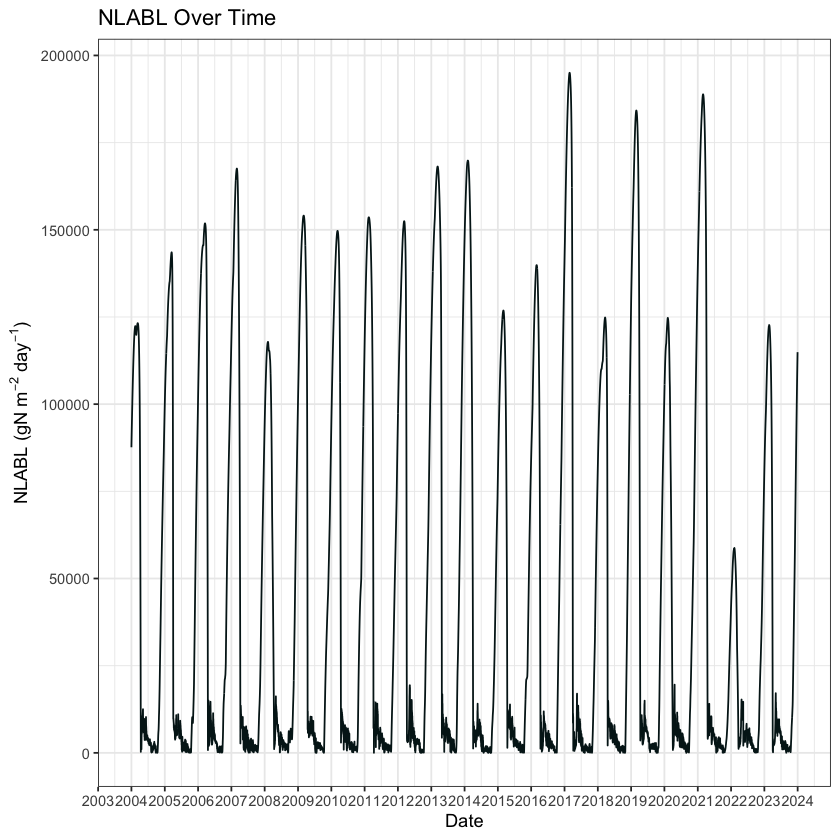

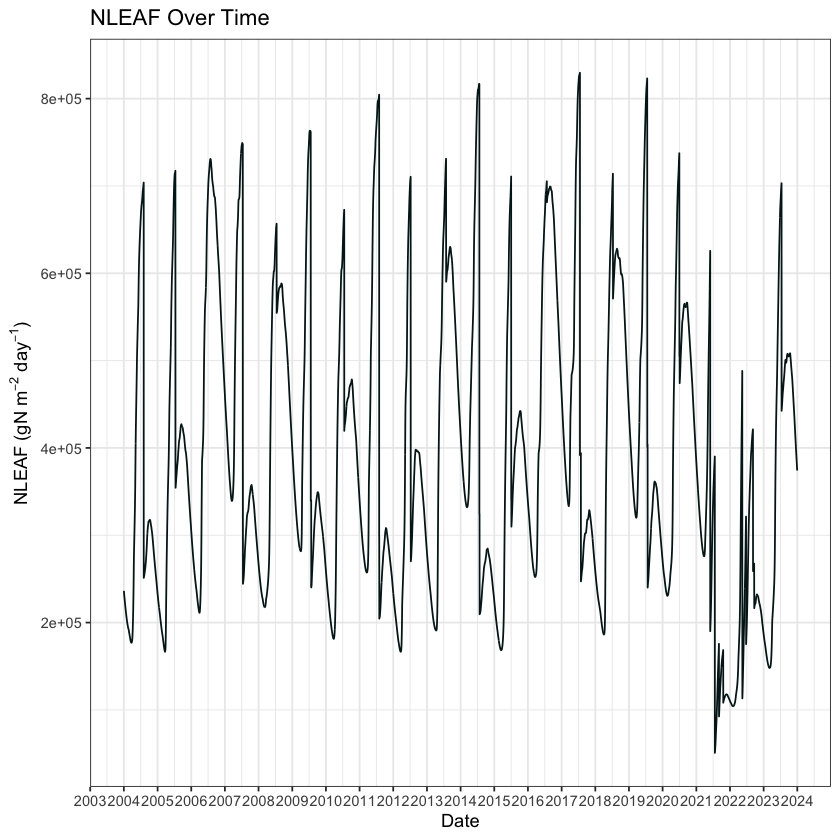

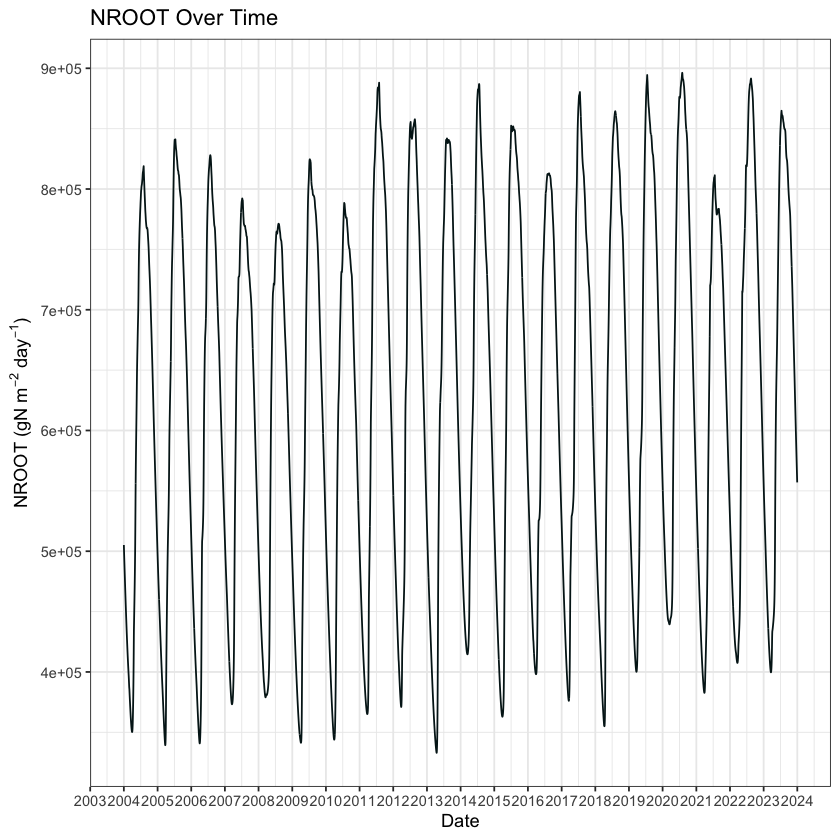

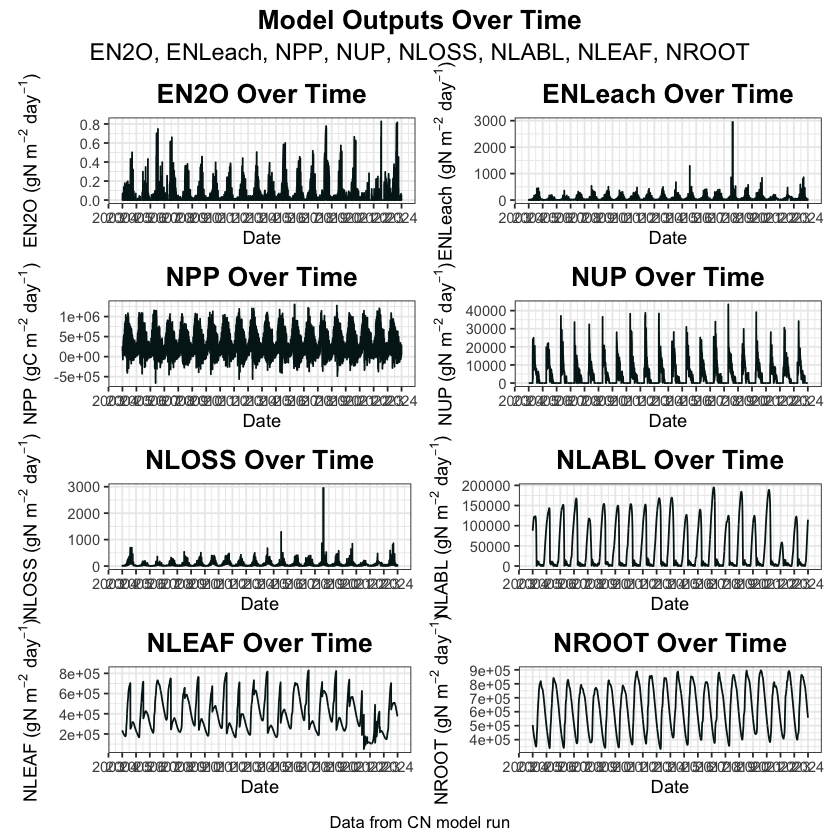

In [125]:
# Plot GPP over time
plot_gpp <- ggplot(output_04_23$data[[1]], aes(x = date, y = gpp)) +
    geom_line(color = "#03191b") +
    labs(title = "GPP Over Time",
             x = "Date",
             y = expression(paste("GPP (gC m"^-2, " day"^-1, ")"))) +
    scale_x_date(date_labels = "%Y", date_breaks = "1 year") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    theme_bw() +
    theme(panel.grid.major.y = element_line())

# Save the GPP plot
ggsave("../output/gpp_plot.png", plot_gpp, width = 14, height = 4, dpi = 300, bg = "white")
plot_gpp

# Plot NPP over time
plot_npp <- ggplot(output_04_23$data[[1]], aes(x = date, y = npp)) +
    geom_line(color = "#03191b") +
    labs(title = "NPP Over Time",
             x = "Date",
             y = expression(paste("NPP (gC m"^-2, " day"^-1, ")"))) +
    scale_x_date(date_labels = "%Y", date_breaks = "1 year") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    theme_bw() +
    theme(panel.grid.major.y = element_line())

# Save the NPP plot
ggsave("../output/npp_plot.png", plot_npp, width = 14, height = 4, dpi = 300, bg = "white")
plot_npp


# Plot EN2O over time
plot_en2o <- ggplot(output_04_23$data[[1]], aes(x = date, y = en2o)) +
    geom_line(color = "#03191b") +
    labs(title = "EN2O Over Time",
             x = "Date",
             y = expression(paste("EN2O (gN m"^-2, " day"^-1, ")"))) +
    scale_x_date(date_labels = "%Y", date_breaks = "1 year") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    theme_bw() +
    theme(panel.grid.major.y = element_line())

# Save the EN2O plot
ggsave("../output/en2o_plot.png", plot_en2o, width = 14, height = 4, dpi = 300, bg = "white")
plot_en2o

# Plot ENLeach over time
plot_enleach <- ggplot(output_04_23$data[[1]], aes(x = date, y = enleach)) +
    geom_line(color = "#03191b") +
    labs(title = "ENLeach Over Time",
             x = "Date",
             y = expression(paste("ENLeach (gN m"^-2, " day"^-1, ")"))) +
    scale_x_date(date_labels = "%Y", date_breaks = "1 year") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    theme_bw() +
    theme(panel.grid.major.y = element_line())

# Save the ENLeach plot
ggsave("../output/enleach_plot.png", plot_enleach, width = 14, height = 4, dpi = 300, bg = "white")
plot_enleach

# Plot NPP over time
plot_npp <- ggplot(output_04_23$data[[1]], aes(x = date, y = npp)) +
    geom_line(color = "#03191b") +
    labs(title = "NPP Over Time",
             x = "Date",
             y = expression(paste("NPP (gC m"^-2, " day"^-1, ")"))) +
    scale_x_date(date_labels = "%Y", date_breaks = "1 year") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    theme_bw() +
    theme(panel.grid.major.y = element_line())

# Save the NPP plot
ggsave("../output/npp_plot.png", plot_npp, width = 14, height = 4, dpi = 300, bg = "white")
plot_npp

# Plot NUP over time
plot_nup <- ggplot(output_04_23$data[[1]], aes(x = date, y = nup)) +
    geom_line(color = "#03191b") +
    labs(title = "NUP Over Time",
             x = "Date",
             y = expression(paste("NUP (gN m"^-2, " day"^-1, ")"))) +
    scale_x_date(date_labels = "%Y", date_breaks = "1 year") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    theme_bw() +
    theme(panel.grid.major.y = element_line())

# Save the NUP plot
ggsave("../output/nup_plot.png", plot_nup, width = 14, height = 4, dpi = 300, bg = "white")
plot_nup

# Plot NLOSS over time
plot_nloss <- ggplot(output_04_23$data[[1]], aes(x = date, y = nloss)) +
    geom_line(color = "#03191b") +
    labs(title = "NLOSS Over Time",
             x = "Date",
             y = expression(paste("NLOSS (gN m"^-2, " day"^-1, ")"))) +
    scale_x_date(date_labels = "%Y", date_breaks = "1 year") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    theme_bw() +
    theme(panel.grid.major.y = element_line())

# Save the NLOSS plot
ggsave("../output/nloss_plot.png", plot_nloss, width = 14, height = 4, dpi = 300, bg = "white")
plot_nloss

# Plot NLABL over time
plot_nlabl <- ggplot(output_04_23$data[[1]], aes(x = date, y = nlabl)) +
    geom_line(color = "#03191b") +
    labs(title = "NLABL Over Time",
             x = "Date",
             y = expression(paste("NLABL (gN m"^-2, " day"^-1, ")"))) +
    scale_x_date(date_labels = "%Y", date_breaks = "1 year") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    theme_bw() +
    theme(panel.grid.major.y = element_line())

# Save the NLABL plot
ggsave("../output/nlabl_plot.png", plot_nlabl, width = 14, height = 4, dpi = 300, bg = "white")
plot_nlabl

# Plot NLEAF over time
plot_nleaf <- ggplot(output_04_23$data[[1]], aes(x = date, y = nleaf)) +
    geom_line(color = "#03191b") +
    labs(title = "NLEAF Over Time",
             x = "Date",
             y = expression(paste("NLEAF (gN m"^-2, " day"^-1, ")"))) +
    scale_x_date(date_labels = "%Y", date_breaks = "1 year") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    theme_bw() +
    theme(panel.grid.major.y = element_line())

# Save the NLEAF plot
ggsave("../output/nleaf_plot.png", plot_nleaf, width = 14, height = 4, dpi = 300, bg = "white")
plot_nleaf

# Plot NROOT over time
plot_nroot <- ggplot(output_04_23$data[[1]], aes(x = date, y = nroot)) +
    geom_line(color = "#03191b") +
    labs(title = "NROOT Over Time",
             x = "Date",
             y = expression(paste("NROOT (gN m"^-2, " day"^-1, ")"))) +
    scale_x_date(date_labels = "%Y", date_breaks = "1 year") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    theme_bw() +
    theme(panel.grid.major.y = element_line())

# Save the NROOT plot
ggsave("../output/nroot_plot.png", plot_nroot, width = 14, height = 4, dpi = 300, bg = "white")
plot_nroot

# Combine all plots into a single figure
combined_plot <- (plot_en2o + plot_enleach + plot_npp + plot_nup) /
                                 (plot_nloss + plot_nlabl + plot_nleaf + plot_nroot) +
                                 plot_layout(ncol = 1) +
                                 plot_annotation(title = "Model Outputs Over Time",
                                                                subtitle = "EN2O, ENLeach, NPP, NUP, NLOSS, NLABL, NLEAF, NROOT",
                                                                caption = "Data from CN model run") &
                                 theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
                                             plot.subtitle = element_text(hjust = 0.5, size = 14),
                                             plot.caption = element_text(hjust = 0.5, size = 10))

# Save the combined plot
ggsave("../output/combined_model_outputs.png", combined_plot, width = 16, height = 12, dpi = 300, bg = "white")
combined_plot

# plot fabio's data

In [126]:
# read fabio data
library(readxl)
flux_meteo <- read_excel("../data/fabio_2004_2023/flux_meteo.xlsx", 
     col_types = c("date", "numeric", "numeric", 
         "numeric", "text", "text", "text", 
         "text", "numeric", "text", "text", 
         "text", "text", "numeric", "text", 
        "text", "text", "text", "text", "text", 
        "text", "text", "text", "text", "text", 
        "text", "text", "text", "text", "text", 
        "text", "text", "text", "text", "text", 
        "text", "text", "text"))
# remove first row
flux_meteo <- flux_meteo[-1, ]
# check the data
head(flux_meteo)
# select specific columns
flux_meteo <- flux_meteo %>%
  select(date,
        flux_nee_qcf_f_mds,
        flux_n2o_qcf,
        flux_ch4_qcf,
        gpp_u50_f_reddyproc)
# rename columns
colnames(flux_meteo) <- c("date", "nee", "n2o", "ch4", "gpp")
# convert date column to Date type
flux_meteo$date <- as.Date(flux_meteo$date, format = "%Y-%m-%d")
# check the data
head(flux_meteo)

Warning message:
"Expecting date in A2 / R2C1: got 'mm-dd-yyyy'"
Warning message:
"Expecting numeric in B2 / R2C2: got 'umol CO2 m-2 s-1'"
Warning message:
"Expecting numeric in C2 / R2C3: got 'nmol N2O m-2 s-1'"
Warning message:
"Expecting numeric in D2 / R2C4: got 'nmol N2O m-2 s-1'"
Warning message:
"Expecting numeric in I2 / R2C9: got 'umol CO2 m-2 s-1'"
New names:
* `ppfd_dif` -> `ppfd_dif...11`
* `ppfd_dif` -> `ppfd_dif...12`
* `P_ERA` -> `P_ERA...32`
* `P_ERA` -> `P_ERA...33`


date,flux_nee_qcf_f_mds,flux_n2o_qcf,flux_n2o_qcf0,flux_n2o_qcf_f-rf,flux_ch4_qcf,flux_ch4_qcf0,flux_ch4_qcf_f-rf,gpp_u50_f_reddyproc,pa,...,wfps_0.15,wfps_0.3,wfps_0.5,P_ERA...32,P_ERA...33,cloud_cover,ccov_ERA5,tmin,tmax,tmean
<dttm>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2021-01-01,0.9360815,NA,NA,NA,NA,NA,NA,0.6533082,95258.175900000002,...,81.372253650000005,82.380677689999999,76.414358780000001,5.0369999999999999,5.8298611111111113E-5,1,100,-0.34699999999999998,2.0249999999999999,0.71458333333333302
2021-01-02,1.3703803,NA,NA,NA,NA,NA,NA,0.2840856,95411.575760000007,...,81.287651969999999,82.710891619999998,76.550551709999993,0.98,1.1342592592592593E-5,1,100,0.68799999999999994,1.907,1.376125
2021-01-03,0.8637366,NA,NA,NA,NA,NA,NA,0.6143411,95497.119420000003,...,69.638811360000005,76.857034299999995,76.671957890000002,1.2969999999999999,1.5011574074074072E-5,1,100,-2.0880000000000001,0.88500000000000001,-0.147145833333333
2021-01-04,0.6757185,NA,NA,NA,NA,NA,NA,0.7801266,95535.177849999993,...,66.219201179999999,64.413349220000001,77.03003966,2.3E-2,2.6620370370370367E-7,0.99399149417877197,99.399149417877197,-2.2389999999999999,0.22600000000000001,-0.66268749999999998
2021-01-05,0.7666215,NA,NA,NA,NA,NA,NA,0.7111028,95579.506259999995,...,66.250472509999994,62.44137147,73.223101580000005,0.11899999999999999,1.3773148148148147E-6,0.99479198455810502,99.479198455810504,-1.145,-0.34499999999999997,-0.71412500000000001
2021-01-06,0.4907299,NA,NA,NA,NA,NA,NA,1.0214699,95783.761240000007,...,65.509238780000004,61.631158319999997,58.874410900000001,0.995,1.1516203703703705E-5,1,100,-1.171,-0.41899999999999998,-0.74583333333333302


date,nee,n2o,ch4,gpp
<date>,<dbl>,<dbl>,<chr>,<dbl>
2021-01-01,0.9360815,NA,NA,0.6533082
2021-01-02,1.3703803,NA,NA,0.2840856
2021-01-03,0.8637366,NA,NA,0.6143411
2021-01-04,0.6757185,NA,NA,0.7801266
2021-01-05,0.7666215,NA,NA,0.7111028
2021-01-06,0.4907299,NA,NA,1.0214699


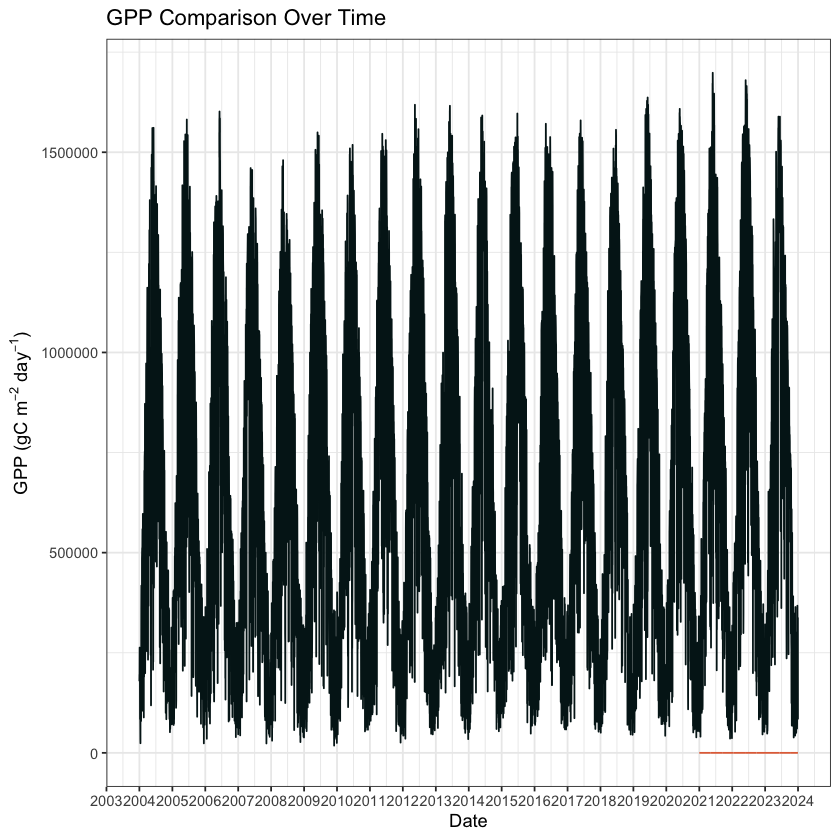

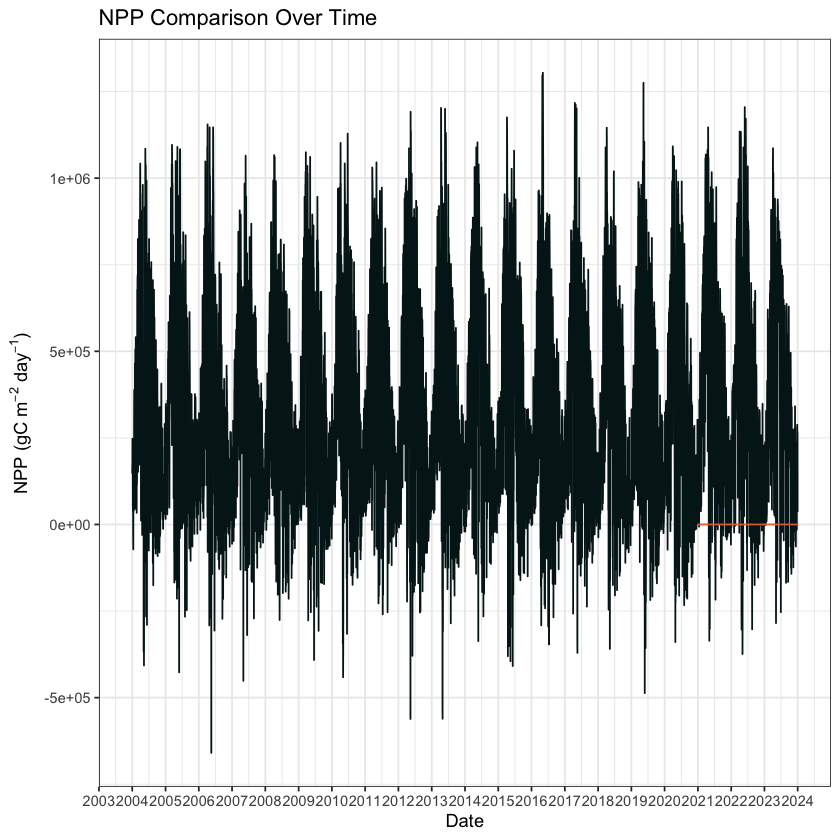

In [127]:
# plot gpp from output_04_23 and fabio data over time in one plot for comparison
plot_gpp_fabio <- ggplot() +
    geom_line(data = output_04_23$data[[1]], aes(x = date, y = gpp), color = "#03191b", size = 0.5) +
    geom_line(data = flux_meteo, aes(x = date, y = gpp), color = "#e26f46", size = 0.5) +
    labs(title = "GPP Comparison Over Time",
             x = "Date",
             y = expression(paste("GPP (gC m"^-2, " day"^-1, ")"))) +
    scale_x_date(date_labels = "%Y", date_breaks = "1 year") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    theme_bw() +
    theme(panel.grid.major.y = element_line())
# Save the GPP comparison plot
ggsave("../output/gpp_comparison_plot.png", plot_gpp_fabio, width = 14, height = 4, dpi = 300, bg = "white")
plot_gpp_fabio

# Plot NPP from output_04_23 and fabio data over time in one plot for comparison
plot_npp_fabio <- ggplot() +
    geom_line(data = output_04_23$data[[1]], aes(x = date, y = npp), color = "#03191b", size = 0.5) +
    geom_line(data = flux_meteo, aes(x = date, y = nee), color = "#e26f46", size = 0.5) +
    labs(title = "NPP Comparison Over Time",
             x = "Date",
             y = expression(paste("NPP (gC m"^-2, " day"^-1, ")"))) +
    scale_x_date(date_labels = "%Y", date_breaks = "1 year") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    theme_bw() +
    theme(panel.grid.major.y = element_line())
# Save the NPP comparison plot
ggsave("../output/npp_comparison_plot.png", plot_npp_fabio, width = 14, height = 4, dpi = 300, bg = "white")
plot_npp_fabio